<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# Training Validation and Testing #
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2020 University of Illinois Board of Trustees. All Rights Reserved.

### imports and graphics configurations ###

In [ ]:
import os
import numpy
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
import sklearn.linear_model
import sklearn.model_selection

import imageio
import PIL

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")

def legend(pos="bottom",ncol=3):
    if pos=="bottom":
        plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5
}
plt.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
print([os.remove(f) for f in pngfiles])

existing png files: ['availabledata.png', 'availabledata_split_by_2.png', 'availabledata_split_by_3.png', 'fold_1.png', 'fold_2.png', 'fold_3.png', 'fold_sets.png', 'overfitting.png', 'performance.png', 'poly.png', 'testing_bestcurve.png', 'training_data.png', 'training_validation.png', 'training_validation_bestcurve.png', 'ValidationCurve.png']
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


### configuration variables###

In [ ]:
SEED=0
markersize=5
thinlinewidth=2
textboxsize=(5,0.5)

In [ ]:
x_min=0
x_max=10
N_train=15
N_validate=5
N_test=5
degree_range=list(range(7))
SEED_train=0
SEED_validate=1
SEED_test=2
color_train="red"
color_validate="blue"
color_test="forestgreen"

### code starts here###

In [ ]:
xrange=numpy.linspace(start=x_min,stop=x_max,num=500)


def data(n,SEED=SEED):
    xvals=scipy.stats.uniform.rvs(loc=0,scale=x_max,random_state=SEED,size=n)
    sigma=1
    signal=20-6*xvals+0.5*xvals**2
    noise=scipy.stats.norm.rvs(scale=sigma,size=n,random_state=SEED)
    yvals=signal+noise
    return numpy.vstack([xvals,yvals]).T

class extract:
    #input is list of form [(x_1,y_2),(x_2,y_2) . . . ]
    @staticmethod
    def x(in_array):
        out,_=list(zip(*in_array))
        return out

    @staticmethod
    def y(in_array):
        _,out=list(zip(*in_array))
        return out

#### training data ####

In [ ]:
xy_train=data(N_train,SEED=SEED_train)

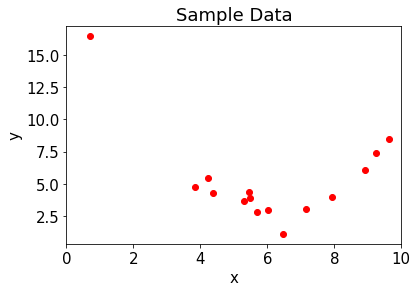

In [ ]:
(y_min,y_max)=(numpy.min(extract.y(xy_train)),numpy.max(extract.y(xy_train)))
plt.figure()
plt.scatter(extract.x(xy_train),extract.y(xy_train),color=color_train)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0,x_max)
title=[]
title.append("Sample Data")
plt.title("\n".join(title))
saver("training_data")
plt.show()
plt.close()

In [ ]:
class PolynomialApproximation:
    def __init__(self,xy):
        self.x=extract.x(xy)
        self.y=extract.y(xy)
        self.reg = sklearn.linear_model.LinearRegression(fit_intercept=False)
        self.coeffs=None
        self.degree=None

    def allpowers(self,x):
        assert (self.degree is not None)
        return numpy.array([numpy.power(x,n) for n in list(range(self.degree+1))]).T

    def set_degree(self,degree):
        self.degree=int(degree)
        self.reg.fit(self.allpowers(self.x),self.y)
        self.coeffs=self.reg.coef_
        return self

    def P(self,x):
        return self.allpowers(x).dot(self.coeffs)

    def err(self,xy):
        y_predict=self.P(extract.x(xy))
        return extract.y(xy)-y_predict

    def loss(self,xy):
        return numpy.average(self.err(xy)**2)

    def metric(self,xy):
        return numpy.mean(numpy.abs(self.err(xy)))

PA=PolynomialApproximation(xy_train)

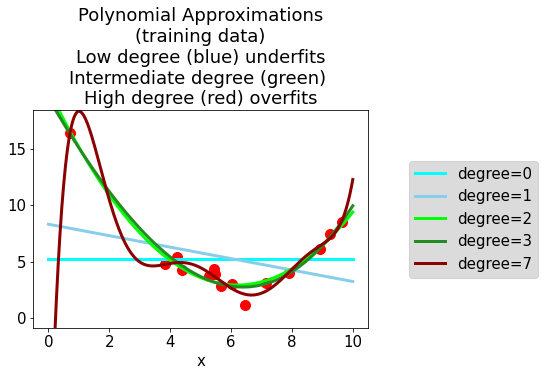

In [ ]:
degrees={0:"cyan",1:"skyblue",2:"lime",3:"forestgreen",7:"darkred"}
plt.figure()
plt.scatter(extract.x(xy_train),extract.y(xy_train),color=color_train,s=100)
for d,c in degrees.items():
    PA.set_degree(d)
    plt.plot(xrange,PA.P(xrange),label="degree={0:d}".format(d),linewidth=3,color=c)

plt.ylim(y_min-2,y_max+2)
plt.xlabel("x")
legend("side")
title=[]
title.append("Polynomial Approximations")
title.append("(training data)")
title.append("Low degree (blue) underfits")
title.append("Intermediate degree (green) ")
title.append("High degree (red) overfits")
plt.title("\n".join(title))
saver("overfitting")
plt.show()
plt.close()

#### validation data ####

In [ ]:
xy_validate=data(N_validate,SEED=SEED_validate)

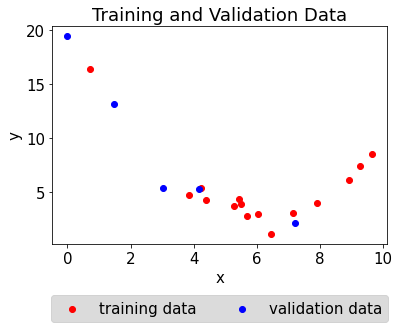

In [ ]:
plt.figure()
plt.scatter(extract.x(xy_train),extract.y(xy_train),color=color_train,label="training data")
plt.scatter(extract.x(xy_validate),extract.y(xy_validate),color=color_validate,label="validation data")
plt.xlabel("x")
plt.ylabel("y")
title=["Training and Validation Data"]
plt.title("\n".join(title))
legend("bottom")
saver("training_validation")
plt.show()
plt.close()

In [ ]:
validation=pandas.Series([PA.set_degree(d).metric(xy_validate) for d in degree_range],index=degree_range)
validation

0     5.073993
1     4.316441
2     0.963073
3     0.779820
4     1.124682
5     4.352983
6    14.309211
dtype: float64

In [ ]:
degree_best=validation.idxmin()
metric_best=validation.min()
underfitting=validation[validation.index<degree_best]
overfitting=validation[validation.index>degree_best]

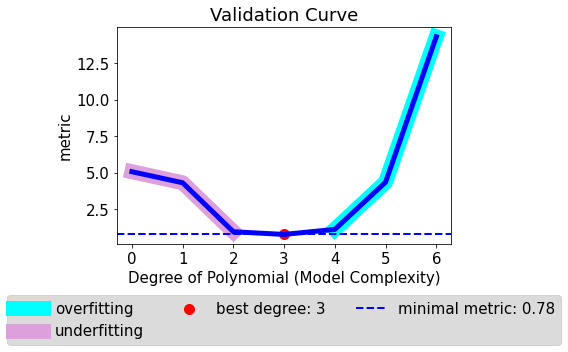

In [ ]:
plt.figure()
plt.plot(validation.index,validation.values,color="blue")
plt.plot(overfitting.index,overfitting.values,color="cyan",linewidth=15,label="overfitting",zorder=-4)
plt.plot(underfitting.index,underfitting.values,color="plum",linewidth=15,label="underfitting",zorder=-4)
plt.scatter(degree_best,metric_best,s=100,color="red",label="best degree: {0:.0f}".format(degree_best))
plt.axhline(metric_best,color=color_validate,label="minimal metric: {0:.2f}".format(metric_best),ls="dashed",linewidth=2)
title=[]
title.append("Validation Curve")
plt.title("\n".join(title))
plt.xlabel("Degree of Polynomial (Model Complexity)")
plt.ylabel("metric")
legend("bottom")
saver("ValidationCurve")
plt.show()
plt.close()

#### test data ####

In [ ]:
xy_test=data(N_test,SEED=SEED_test)

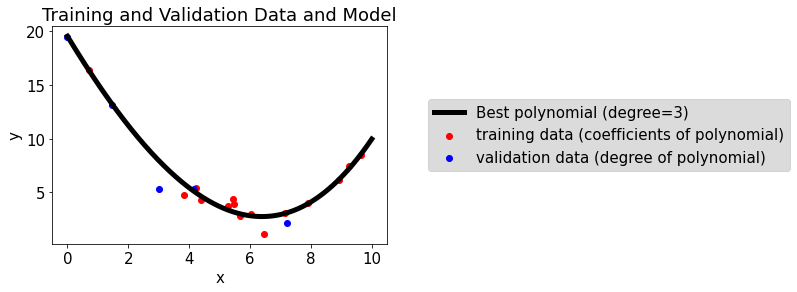

In [ ]:
plt.figure()
PA.set_degree(degree_best)
plt.plot(xrange,PA.P(xrange),color="black",label="Best polynomial (degree={0:.0f})".format(degree_best))
plt.scatter(extract.x(xy_train),extract.y(xy_train),color=color_train,label="training data (coefficients of polynomial)")
plt.scatter(extract.x(xy_validate),extract.y(xy_validate),color=color_validate,label="validation data (degree of polynomial)")
plt.xlabel("x")
plt.ylabel("y")
title=["Training and Validation Data and Model"]
plt.title("\n".join(title))
legend("side")
saver("training_validation_bestcurve")
plt.show()
plt.close()

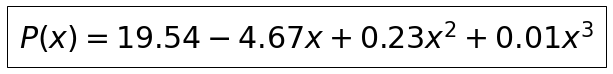

In [ ]:
txt="P(x)="
for (d,c) in enumerate(PA.coeffs):
    if d==0:
        s=r"{0:.2f}".format(c)
    elif d==1:
        s=r"{0:+.2f}x".format(c)
    else:
        s=r"{0:+.2f}x^{1:}".format(c,d)
    txt+=s

txt="$"+txt+"$"
textbox([txt],fname="poly")

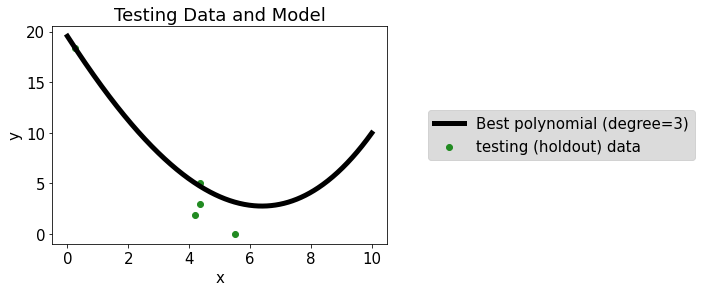

In [ ]:
plt.figure()
PA.set_degree(degree_best)
plt.plot(xrange,PA.P(xrange),color="black",label="Best polynomial (degree={0:.0f})".format(degree_best))
plt.scatter(extract.x(xy_test),extract.y(xy_test),color=color_test,label="testing (holdout) data")
plt.xlabel("x")
plt.ylabel("y")
title=["Testing Data and Model"]
plt.title("\n".join(title))
legend("side")
saver("testing_bestcurve")
plt.show()
plt.close()

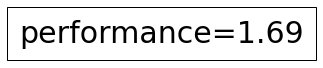

In [ ]:
#PA still is using best_degree
performance=PA.metric(xy_test)
text=[]
text.append("performance={0:.2f}".format(performance))
#text_str.append(r"$\sup|F_e-F_t|$={0:.2f}".format(maxval))
plt.figure(figsize=(1,1))
plt.gca().add_artist(offsetbox.AnchoredText("\n".join(text), loc="center",prop=dict(size=30)))
plt.axis('off')
saver("performance")
plt.show()
plt.close()

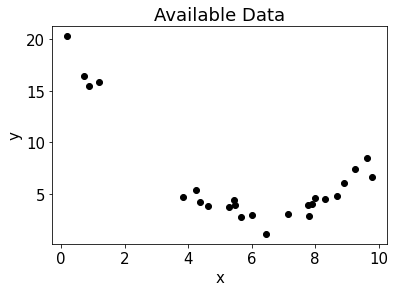

In [ ]:
xy_total=data(N_train+N_validate+N_test)
plt.figure()
plt.scatter(extract.x(xy_total),extract.y(xy_total),color="black")
plt.xlabel("x")
plt.ylabel("y")
title=["Available Data"]
plt.title("\n".join(title))
saver("availabledata")
plt.show()
plt.close()

In [ ]:
xy_total_trainvalidate,xy_total_test=sklearn.model_selection.train_test_split(xy_total,random_state=SEED,test_size=N_test)
xy_total_train,xy_total_validate=sklearn.model_selection.train_test_split(xy_total_trainvalidate,random_state=SEED,test_size=N_validate)

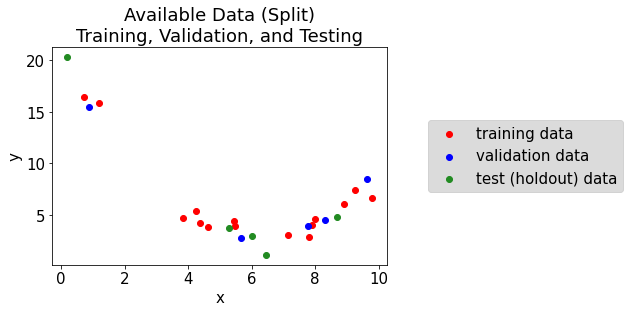

In [ ]:
plt.figure()
plt.scatter(extract.x(xy_total_train),extract.y(xy_total_train),color=color_train,label="training data")
plt.scatter(extract.x(xy_total_validate),extract.y(xy_total_validate),color=color_validate,label="validation data")
plt.scatter(extract.x(xy_total_test),extract.y(xy_total_test),color=color_test,label="test (holdout) data")
plt.xlabel("x")
plt.ylabel("y")
title=[]
title.append("Available Data (Split)")
title.append("Training, Validation, and Testing")
plt.title("\n".join(title))
legend("side")
saver("availabledata_split_by_3")
plt.show()
plt.close()

### K-fold cross-validation ###

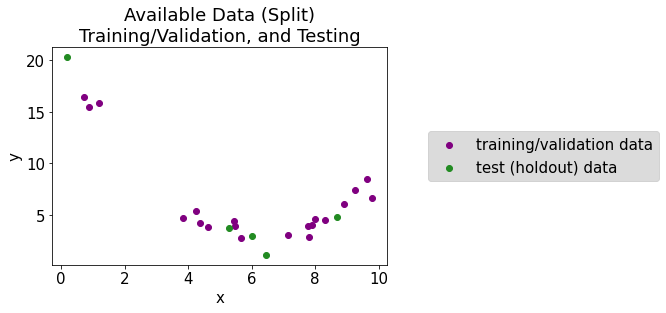

In [ ]:
plt.figure()
plt.scatter(extract.x(xy_total_trainvalidate),extract.y(xy_total_trainvalidate),color="purple",label="training/validation data")
plt.scatter(extract.x(xy_total_test),extract.y(xy_total_test),color=color_test,label="test (holdout) data")
plt.xlabel("x")
plt.ylabel("y")
title=[]
title.append("Available Data (Split)")
title.append("Training/Validation, and Testing")
plt.title("\n".join(title))
legend("side")
saver("availabledata_split_by_2")
plt.show()
plt.close()

#### create folds ####

In [ ]:
K_folds=3
kf = sklearn.model_selection.KFold(n_splits=K_folds,random_state=SEED,shuffle=True)
splits=list(kf.split(xy_total_trainvalidate))

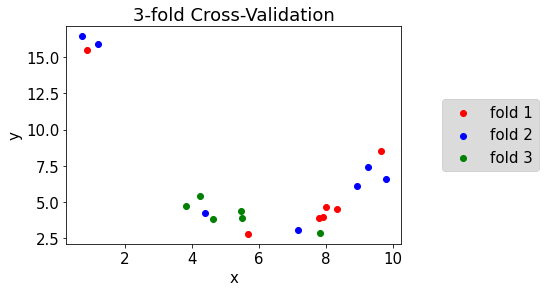

In [ ]:
colors=["red","blue","green"]
plt.figure()
for n,(split,c) in enumerate(zip([s for _,s in splits],["red","blue","green"])):
    plt.scatter(extract.x(xy_total_trainvalidate[split]),extract.y(xy_total_trainvalidate[split]),color=c,label="fold {0:.0f}".format(n+1))
title=[]
title.append("{0:.0f}-fold Cross-Validation".format(K_folds))
plt.title("\n".join(title))
plt.xlabel("x")
plt.ylabel("y")
legend("side")
saver("fold_sets")
plt.show()
plt.close()

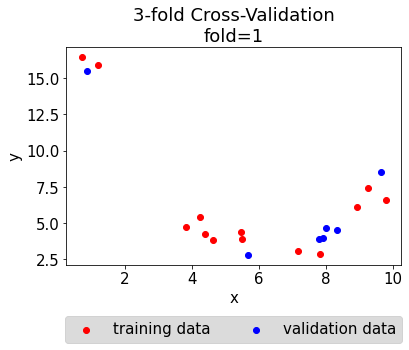

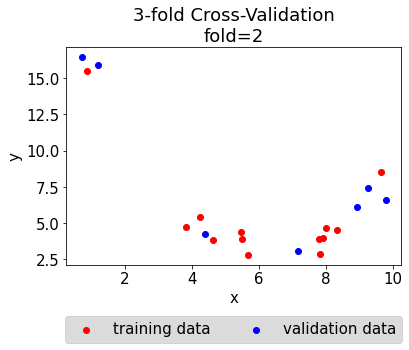

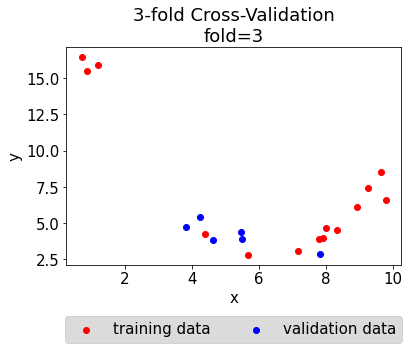

In [ ]:
for n,(train_index,validate_index) in enumerate(splits):
    plt.figure()
    plt.scatter(extract.x(xy_total_trainvalidate[train_index]),extract.y(xy_total_trainvalidate[train_index]),color=color_train,label="training data")
    plt.scatter(extract.x(xy_total_trainvalidate[validate_index]),extract.y(xy_total_trainvalidate[validate_index]),color=color_validate,label="validation data")
    title=[]
    title.append("{0:.0f}-fold Cross-Validation".format(K_folds))
    title.append("fold={0:.0f}".format(n+1))
    plt.title("\n".join(title))
    plt.xlabel("x")
    plt.ylabel("y")
    legend("bottom")
    saver("fold_{0:.0f}".format(n+1))
    plt.show()
    plt.close()

In [ ]:
crossvalidation=pandas.DataFrame(numpy.nan,index=degree_range,columns=range(1,K_folds+1))
crossvalidation.index.name="degree"
crossvalidation.columns.name="fold"

In [ ]:
for n,(train_index,validate_index) in enumerate(splits):
    thisPA=PolynomialApproximation(xy_total_trainvalidate[train_index])
    v=[thisPA.set_degree(d).metric(xy_total_trainvalidate[validate_index]) for d in degree_range]
    crossvalidation[n+1]=v

mean_crossvalidation=crossvalidation.mean(axis="columns")

In [ ]:
degree_best_crossvalidation=mean_crossvalidation.idxmin()
metric_best_crossvalidation=mean_crossvalidation.min()
overfitting_crossvalidation=mean_crossvalidation[mean_crossvalidation.index>degree_best_crossvalidation]
underfitting_crossvalidation=mean_crossvalidation[mean_crossvalidation.index<degree_best_crossvalidation]

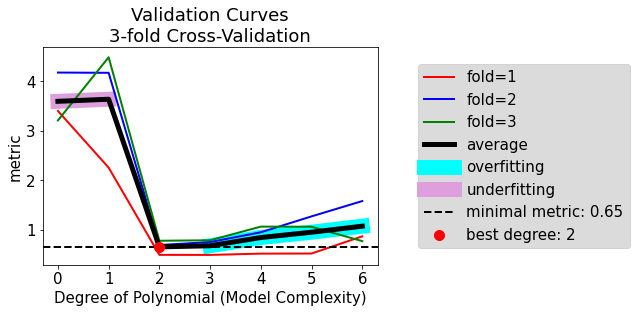

In [ ]:
plt.figure()
for (fold,v),c in zip(crossvalidation.items(),["red","blue","green"]):
    plt.plot(degree_range,v,label="fold={0:.0f}".format(fold),color=c,linewidth=2)
plt.plot(degree_range,mean_crossvalidation,label="average",color="black")
plt.plot(overfitting_crossvalidation.index,overfitting_crossvalidation.values,color="cyan",linewidth=15,label="overfitting",zorder=-4)
plt.plot(underfitting_crossvalidation.index,underfitting_crossvalidation.values,color="plum",linewidth=15,label="underfitting",zorder=-4)
plt.axhline(metric_best_crossvalidation,color="black",label="minimal metric: {0:.2f}".format(metric_best_crossvalidation),ls="dashed",linewidth=2)
plt.scatter(degree_best_crossvalidation,metric_best_crossvalidation,s=100,color="red",zorder=5,label="best degree: {0:.0f}".format(degree_best_crossvalidation))
plt.xlabel("Degree of Polynomial (Model Complexity)")
plt.ylabel("metric")
title=[]
title.append("Validation Curves")
title.append("{0:.0f}-fold Cross-Validation".format(K_folds))
plt.title("\n".join(title))
legend("side")
saver("CrossValidationCurve")
plt.show()
plt.close()


In [ ]:
kfoldPA=PolynomialApproximation(xy_total_trainvalidate)
kfoldPA.set_degree(degree_best_crossvalidation)

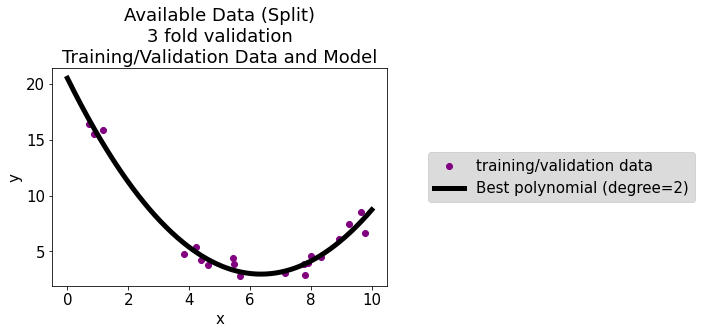

In [ ]:
plt.figure()
plt.scatter(extract.x(xy_total_trainvalidate),extract.y(xy_total_trainvalidate),color="purple",label="training/validation data")
plt.plot(xrange,kfoldPA.P(xrange),color="black",label="Best polynomial (degree={0:.0f})".format(degree_best_crossvalidation))
plt.xlabel("x")
plt.ylabel("y")
title=[]
title.append("Available Data (Split)")
title.append("{0:.0f} fold validation".format(K_folds))
title.append("Training/Validation Data and Model")
plt.title("\n".join(title))
legend("side")
saver("availabledata_split_by2_model")
plt.show()
plt.close()

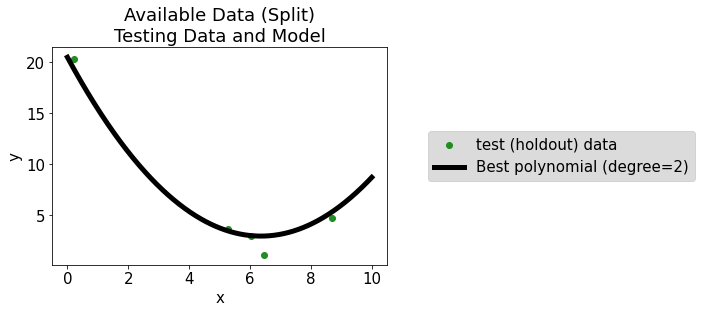

In [ ]:
plt.figure()
plt.scatter(extract.x(xy_total_test),extract.y(xy_total_test),color=color_test,label="test (holdout) data")
plt.plot(xrange,kfoldPA.P(xrange),color="black",label="Best polynomial (degree={0:.0f})".format(degree_best_crossvalidation))
plt.xlabel("x")
plt.ylabel("y")
title=[]
title.append("Available Data (Split)")
title.append("Testing Data and Model")
plt.title("\n".join(title))
legend("side")
saver("availabledata_split_by2_test")
plt.show()
plt.close()

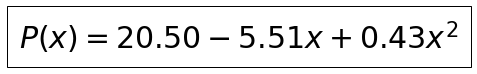

In [ ]:
txt="P(x)="
for (d,c) in enumerate(kfoldPA.coeffs):
    if d==0:
        s=r"{0:.2f}".format(c)
    elif d==1:
        s=r"{0:+.2f}x".format(c)
    else:
        s=r"{0:+.2f}x^{1:}".format(c,d)
    txt+=s

txt="$"+txt+"$"
textbox([txt],fname="kpoly")

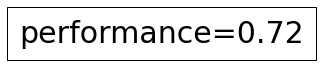

In [ ]:
#kfoldPA still is using best_degree
performance=kfoldPA.metric(xy_total_test)
text=[]
text.append("performance={0:.2f}".format(performance))
#text_str.append(r"$\sup|F_e-F_t|$={0:.2f}".format(maxval))
plt.figure(figsize=(1,1))
plt.gca().add_artist(offsetbox.AnchoredText("\n".join(text), loc="center",prop=dict(size=30)))
plt.axis('off')
saver("performance_kfold")
plt.show()
plt.close()